#### Задание

Реализовать самостоятельно логистическую регрессию на основе dataset’а Iris, оставив 2 класса: Iris Versicolor, Iris Virginica

1. Обучить ее методом градиентного спуска
2. Методом nesterov momentum
3. Методом rmsprop


In [1]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from pandas import DataFrame

In [2]:
iris = datasets.load_iris()

In [3]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [4]:
iris_frame = DataFrame(iris.data)
# Делаем имена колонок такие же, как имена переменных:
iris_frame.columns = iris.feature_names
# Добавляем столбец с целевой переменной: 
iris_frame['target'] = iris.target
# Добавляем столбец с сортами:
iris_frame['name'] = iris_frame.target.apply(lambda x : iris.target_names[x])

iris_frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [5]:
# оставим 2 класса: Iris Versicolor, Iris Virginica (0 — Setosa, 1 — Versicolor, 2 — Virginica)
iris_frame = iris_frame[iris_frame.target != 0].copy()
iris_frame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
50,7.0,3.2,4.7,1.4,1,versicolor
51,6.4,3.2,4.5,1.5,1,versicolor
52,6.9,3.1,4.9,1.5,1,versicolor
53,5.5,2.3,4.0,1.3,1,versicolor
54,6.5,2.8,4.6,1.5,1,versicolor


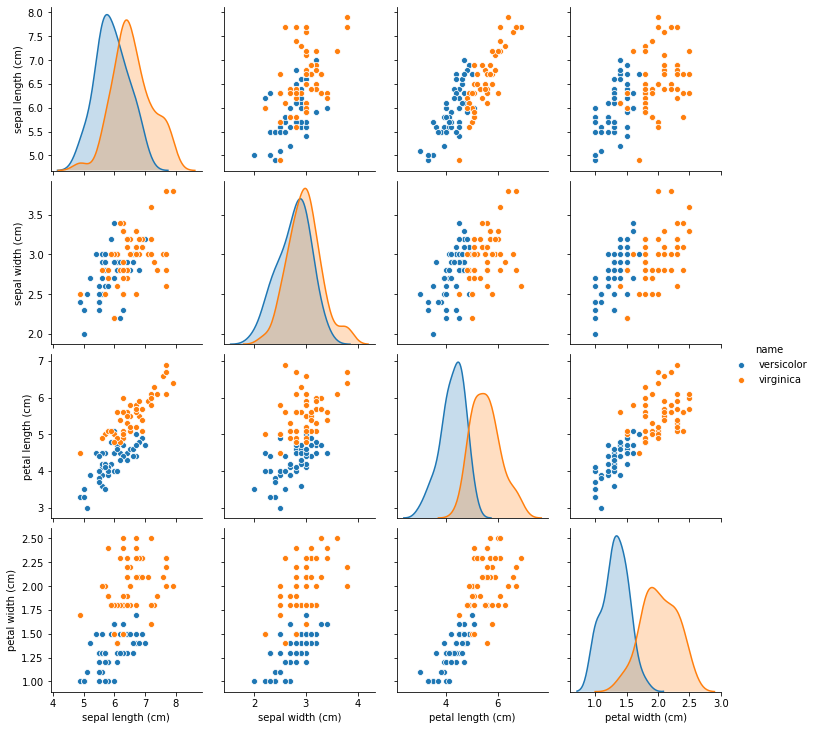

In [6]:
import seaborn as sns
sns.pairplot(iris_frame[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','name']], 
             hue = 'name')

In [7]:
# на графиках видно, что «petal width (cm)» и «petal length (cm)» имеют сильную зависимость — точки вытянуты вдоль одной линии

iris_frame[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,0.553855,0.828479,0.593709
sepal width (cm),0.553855,1.000000,0.519802,0.566203
petal length (cm),0.828479,0.519802,1.000000,0.823348
petal width (cm),0.593709,0.566203,0.823348,1.000000


In [23]:
# «petal width (cm)» и «petal length (cm)» имеют сильную корреляцию (0.82), 
# также sepal length (cm) коррелирует с petal length (cm) (0.83)
# выбираем признаки «petal width (cm)» и «petal length (cm)» для классификации

In [8]:
iris_ = iris_frame.drop(['sepal width (cm)', 'name'], axis = 1)

iris_['area'] = iris_['petal length (cm)'] * iris_['petal width (cm)']
iris0 = iris_.drop(['petal length (cm)', 'petal width (cm)'], axis = 1)

iris0.head()

,sepal length (cm),target,area
50,7.0,1,6.58
51,6.4,1,6.75
52,6.9,1,7.35
53,5.5,1,5.20
54,6.5,1,6.90


In [9]:
iris0['target_'] = iris0['target']
del iris0['target']

iris0.head()

,sepal length (cm),area,target_
50,7.0,6.58,1
51,6.4,6.75,1
52,6.9,7.35,1
53,5.5,5.20,1
54,6.5,6.90,1


In [10]:
iris0['target_'] = iris0['target_'].replace(2, 0)

iris0[iris0['target_'] == 0].head()

,sepal length (cm),area,target_
100,6.3,15.00,0
101,5.8,9.69,0
102,7.1,12.39,0
103,6.3,10.08,0
104,6.5,12.76,0


In [276]:
import numpy as np
from scipy.optimize import fmin_tnc

# Определим функции для расчета стоимости

class LogisticRegressionUsingGD:

    @staticmethod
    def sigmoid(x):
        # Функция активации (sigmoid) используется для отображения любого реального значения между 0 и 1
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def net_input(theta, x):
        # Вычисляет взвешенную сумму входных данных аналогично линейной регрессии
        
        if a == 1:
            theta = np.reshape(theta, (3, 1)) # корректировка размера, не понял почему он меняется

        return np.dot(x, theta)

    def probability(self, theta, x):
        # Вычисляет вероятность принадлежности экземпляра к определенному классу

        return self.sigmoid(self.net_input(theta, x))

    def cost_function(self, theta, x, y):
        # Вычисляет функцию стоимости для всех обучающих выборок
        
        m = x.shape[0]
        total_cost = -(1 / m) * np.sum(
            y * np.log(self.probability(theta, x)) + 
            (1 - y) * np.log(1 - self.probability(theta, x)))
        
        return total_cost

    def gradient(self, theta, x, y):
        # Вычисляет градиент функции стоимости в точке тета
        
        m = x.shape[0]
        return (1 / m) * np.dot(x.T, self.sigmoid(self.net_input(theta, x)) - y)

    def fit(self, x, y, theta):
        """
        Обучает модель на основе обучающих данных training data (X)
        Использует fmin_tnc для поиска минимума функции стоимости (cost_function)
        
        """
        opt_weights = fmin_tnc(func=self.cost_function, x0=theta, fprime=self.gradient,
                               args=(x, y.flatten()))
        self.w_ = opt_weights[0]
        return self

    def predict(self, x):
        """ 
        Предсказывает метки классов
        
        Параметры:
        ----------
        x: array-like, shape = [n_samples, n_features] - тестовая выборка
        
        Возвращает: предсказанные метки классов
        """
        theta = self.w_[:, np.newaxis]
        return self.probability(theta, x)

    def accuracy(self, x, actual_classes, probab_threshold=0.5):
        """
        Вычисляет точность классификатора
        
        Параметры:
        ----------
        x: array-like, shape = [n_samples, n_features] - обучающая выборка
        actual_classes : метки классов из набора обучающих данных
        probab_threshold: пороговое значение для классификации выборок по различным классам
        
        Возвращает: accuracy: точность модели
        """
       
        predicted_classes = (self.predict(x) >= probab_threshold).astype(int)
        predicted_classes = predicted_classes.flatten()
        accuracy = np.mean(predicted_classes == actual_classes)
        return accuracy * 100
    
#___________________________________________________________________________

    #L1 регуляризация
    def __l1_penalty(self):
        return 1/self.C * np.sign(self.theta)
    
    #L2 регуляризация
    def __l2_penalty(self):
        return 1/self.C * self.theta

    def __none_penalty(self):
        return 0
    
    def __init__(self, **kwargs):
        self.C = kwargs.get('C', 1)
        #Коэф. регуляризации
        
        self.alpha = kwargs.get('alpha', 1)               
        # Скорость спуска
        
        self.max_epoch = kwargs.get('max_epoch', 100)      
        #Максимальное количество эпох при обучении модели
 
        self.min_err = kwargs.get('min_err', 0.1)        
        #Пороговое значение ошибки
        
        penalty = kwargs.get('penalty', 'none')           
        #Способ расчета регуляризации
        
        if penalty == 'l1':
            self.penalty = self.__l1_penalty 
        elif penalty == 'l2':
            self.penalty = self.__l2_penalty
        else:
            self.penalty = self.__none_penalty

        self.theta = None
        self.errors = None
        
    #Обучение модели SGD (ручками)
    def fit_(self, x, y):

        n, m = x.shape
        #n - число строк, m - столбцов        

        errors = np.empty(self.max_epoch)
        errors[:] = np.nan
        
        self.theta = np.random.randn(m, 1)
        Y = np.vstack(y)

        for epoch in range(self.max_epoch):

            self.theta = self.theta - self.alpha * (self.gradient(self.theta, x, Y) + self.penalty())
            
            epoch_error = self.cost_function(self.theta, x, Y)
    
            errors[epoch] = epoch_error
        
            if epoch_error <= self.min_err:
                break
        self.errors = errors
        self.w_ = self.theta
        
        return self
#--------------------------------------------

    # Используем продвинутые алгоритмы для оптимизации в седловых точках

    def fit_pro(self, x, y, metod):
        """
        metod:
        AdaGrad - ag
        Nesterov_Accelarated_Gradient - nag
        RMSProp - rms
        Adam - adam
        """
        errors = np.empty(self.max_epoch)
        errors[:] = np.nan
        self.theta = np.zeros((X.shape[1], 1))
        Y = np.vstack(y)   
        g = 0
        gamma = 0.9
        gamma2 = 0.9
        grad = 0
        eps = np.finfo(float).eps
        first_moment = 0
        second_moment = 0
        
        for epoch in range(self.max_epoch):
                
            epoch = epoch + 1
            old_v = self.theta
            
            if metod == 'ag':
                
                grad = grad + self.gradient(self.theta, x, Y)**2
                g = self.gradient(self.theta, x, Y) / (np.sqrt(grad) + eps)
                self.theta = self.theta - self.alpha * g
            
            elif metod == 'nag':
            
                g = gamma * g + (1 - gamma) * self.gradient(self.theta, x, Y)
                self.theta = old_v - self.alpha * g
            
            elif metod == 'rms':
                
                grad = gamma * grad + (1 - gamma)* self.gradient(self.theta, x, Y)**2
                g = self.gradient(self.theta, x, Y) / (np.sqrt(grad) + eps)
                self.theta = self.theta - self.alpha * g
            
            elif metod == 'adam':
                
                first_moment = gamma * first_moment + (1 - gamma) * self.gradient(self.theta, x, Y)
                second_moment = gamma2 * second_moment + (1 - gamma2)* self.gradient(self.theta, x, Y)**2
                
                first_unbias = first_moment / (1 - gamma ** epoch)
                second_unbias = second_moment / (1 - gamma2 ** epoch)
                
                g = first_unbias / (np.sqrt(second_unbias) + eps)
                self.theta = self.theta - self.alpha * g
            
            else:
                print('Вы ввели неизвестный метод')
                break
                
            epoch_error = self.cost_function(self.theta, x, Y)
            
            errors[epoch] = epoch_error
            
            if epoch_error <= self.min_err:
                break
        
        self.errors = errors
        self.w_ = self.theta
        
        return self
    

In [12]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(iris0, test_size=0.5)

Точность модели: 98.0
Параметры модели с использованием градиентного спуска
[[ 0.63289618]
 [ 1.30372204]
 [-1.11088294]]


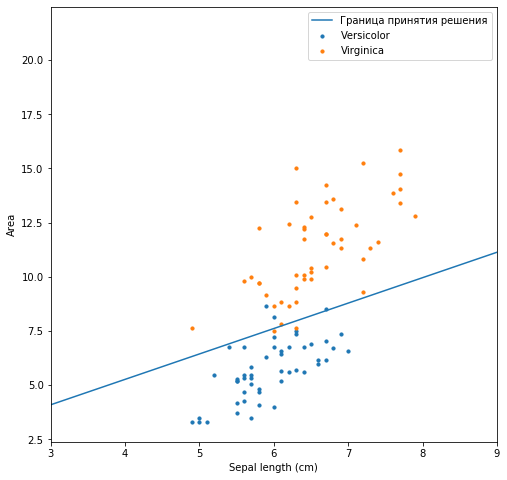

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

a = 1
    # зададим данные
data = data_train

    # y = target значения из data frame
y = data.iloc[:, -1]
y_values = []

    # X = значения объектов, все столбцы, кроме target
X = data.iloc[:, :-1]

    # фильтруем примеры одного класса (y == 1)
Versicolor = iris0[iris0.target_ == 1]

    # фильтруем примеры другого класса (y == 0)
Virginica = iris0[iris0.target_ == 0]

    # график исходных данных
fig = plt.figure(figsize=(8, 8))
plt.xlim([3, 9])
plt.scatter(Versicolor.iloc[:, 0], Versicolor.iloc[:, 1], s=10, label='Versicolor')
plt.scatter(Virginica.iloc[:, 0], Virginica.iloc[:, 1], s=10,
                label='Virginica')

    # подготавливаем данные для построения модели
X = np.c_[np.ones((X.shape[0], 1)), X] # добавляем столбец с единицами
y = y[:, np.newaxis] # переводим y в двухмерный массив
theta = np.zeros((X.shape[1], 1)) # задаем theta нулевым вектором с числом строк по числу столбцов X

    # Применяем логистическую регрессию с использованием градиентного спуска (ручками)
model = LogisticRegressionUsingGD(alpha=.01, max_epoch=1000, penalty = 'l1', C = 100)
model.fit_(X, y)
accuracy = model.accuracy(X, y.flatten())
parameters = model.w_

print("Точность модели: {}".format(accuracy))
print("Параметры модели с использованием градиентного спуска")
print(parameters)

    # Построим границу принятия решения
    # Используем формулу: wo + w1x1 + w2x2 = 0; Значение y тогда: x2 = - (wo + w1x1)/(w2)

x_values = [np.min(X[:, 1] - 2), np.max(X[:, 2] + 2)]
#y_values = - (parameters[0] + np.dot(parameters[1], x_values)) / parameters[2] # при fmin_tnc
y_values = - (parameters[0] + parameters[1] * x_values) / parameters[2]

plt.plot(x_values, y_values, label='Граница принятия решения')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Area')
plt.legend()
plt.show()


In [145]:
    # Применяем логистическую регрессию с использованием градиентного спуска (с fmin_tnc)

theta = np.zeros((X.shape[1], 1)) # задаем theta нулевым вектором с числом строк по числу столбцов X
a = 0
model = LogisticRegressionUsingGD()
model.fit(X, y, theta)
accuracy = model.accuracy(X, y.flatten())
parameters = model.w_

print("Точность модели: {}".format(accuracy))
print("Параметры модели с использованием градиентного спуска")
print(parameters)


Точность модели: 98.0
Параметры модели с использованием градиентного спуска
[ 7.29331887  3.92382177 -3.98627748]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


In [146]:
    # Используем sklearn

model = LogisticRegression()
model.fit(X, y)
parameters = model.coef_
predicted_classes = model.predict(X)
accuracy = accuracy_score(y.flatten(),predicted_classes)

print('The accuracy score using scikit-learn is {}'.format(accuracy))
print("The model parameters using scikit learn")
print(parameters)

The accuracy score using scikit-learn is 0.96
The model parameters using scikit learn
[[-1.35170080e-06  8.39391262e-01 -1.88677051e+00]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [275]:
    # Используем продвинутые алгоритмы оптимизации

theta = np.zeros((X.shape[1], 1)) # задаем theta нулевым вектором с числом строк по числу столбцов X
a = 1

model = LogisticRegressionUsingGD(alpha=.01, max_epoch=1000, penalty = 'l1', C = 100)
model.fit_pro(X, y, metod='adam')
accuracy = model.accuracy(X, y.flatten())
parameters = model.w_

print("Точность модели: {}".format(accuracy))
print("Параметры модели с использованием градиентного спуска")
print(parameters)

Точность модели: 98.0
Параметры модели с использованием градиентного спуска
[[ 1.78665183]
 [ 1.76893723]
 [-1.6226742 ]]
